                                    Practical Data Science, Assignment 1
                                    Vasileios Ilias Drouzas, ID: f3352301
                                    
You are given a dataframe comprising one grouping (of 100 proverbs, one per annotator) per column. Each question, below, will be scored either with [1/10] or [2/10] points. You are expected to submit a notebook (compressed along with other files, named after your student ID number only), including all the images, code, output, and text cells. 

 
A. Assessing the human-based grouping 
1. [1 point] Compute all the pairwise inter-annotator agreement scores on the dataframe you have been provided with, using the Mutual Information (MI) and the adjusted MI (AMI) scores. 
2. [2 points] Report and briefly analyse (50-200 words) their differences. 
 
B. Estimating the ground truth 
1. [1 point] Compute a matrix where rows and columns are the given proverbs, and each cell value comprises the probability that two annotators would put the pair in the same cluster. Use the relative frequency to estimate this probability. 
2. [2 points] Plot the matrix with a heatmap, producing a publication-quality visualisation. \
Hint: Explain how your visualisation meets the standards of a publication-quality visualisation. 
 
C. Clustering 
1. [2 points] Use an LLM to cluster the provided proverbs, generating 5 (or more) different LLM-based clusterings, by changing the role the LLM is instructed to be (e.g., a person living in a different era, city/country, of different gender, age, profession, education, etc). 
2. [2 points] Use the ground truth to assess the clusterings. \
Hint: you should select the proper evaluation measure (e.g., MI or AMI); evaluate each LLM clustering against each human-based clustering; use an appropriate visualisation to show which is the best LLM clustering. 
 
Bonus \
[+1 point] Use the descriptions of the groups of the best LLM clustering, in order to build examples for few-shot learning. Use them to instruct an LLM to classify thousands of other proverbs ([URL of the CSV](https://raw.githubusercontent.com/ipavlopoulos/paremia/main/data/balanced_corpus.csv)), each to the most suitable group. Submit the result of this LLM-based classification as a CSV file.

A1.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file = r"C:\Users\Drogias\OneDrive\Υπολογιστής\MSc Data Science AUEB\1st semester\Practical Data Science\Projects\A1\greek_proverbs_human_clustering.csv"

annot = pd.read_csv(file)
print(annot)

                                                 text  f3352321  f3352310  \
0             Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει         1         1   
1                             Τα 'θελες και τα 'παθες         1         5   
2              Αδειανός μασκαράς, παραχέρ 'τ' χουριού         3         1   
3   Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντ...         3         1   
4           Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε         2         2   
..                                                ...       ...       ...   
95        Σαράντα καλόγεροι, ο καθένας με τον πόνο τ'         4         1   
96                          Θέλει κι ο Μούτσιος καφέ!         1         5   
97         Ξέρεις και συ που πάει του χωριού η αγγέλη         1         5   
98         Επήα να κόψω τ' αυτιά και 'βαλα και κέρατα         1         5   
99            Απού βράσει τζαί στεγνώσει εν έν τίποτε         1         1   

    f3352311  f3352316 f3352318  f3352314  f3352315  f3352301  f3352308  \


In [3]:
annot.dtypes

text         object
f3352321      int64
f3352310      int64
f3352311      int64
f3352316      int64
f3352318     object
f3352314      int64
f3352315      int64
f3352301      int64
f3352308      int64
f3352307      int64
LLMAnnot1     int64
LLMAnnot2     int64
LLMAnnot3     int64
LLMAnnot4     int64
LLMAnnot5     int64
dtype: object

In [4]:
#DATA CLEANING

annot['f3352310'] = annot['f3352310'].astype('int64')                      #Make all columns integers
annot['f3352318'] = pd.to_numeric(annot['f3352318'], errors='coerce', downcast='integer')

for column in annot.columns.values[1:]:                                                  #Replace NA values with -1
    annot[column] = annot[column].fillna(-1).astype(int)

annot.dtypes

text         object
f3352321      int32
f3352310      int32
f3352311      int32
f3352316      int32
f3352318      int32
f3352314      int32
f3352315      int32
f3352301      int32
f3352308      int32
f3352307      int32
LLMAnnot1     int32
LLMAnnot2     int32
LLMAnnot3     int32
LLMAnnot4     int32
LLMAnnot5     int32
dtype: object

Dealing with the missing and NA values, I had the following choices:

1) Replace these values with the value of the most frequent cluster. This minimizes the error without adding a new virtual 'cluster' , but still introduces bias to the cluster that has been affected by this (the most frequently seen one).
2) Replace these values with a different value (in my case, -1). I chose this one because I preferred to have unbiased clusters that absolutely show the truth, and I will still know that the virtual cluster -1 is for all these 'cleaning' cases.

In [5]:
annot.describe()

,f3352321,f3352310,f3352311,f3352316,f3352318,f3352314,f3352315,f3352301,f3352308,f3352307,LLMAnnot1,LLMAnnot2,LLMAnnot3,LLMAnnot4,LLMAnnot5
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.0000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,2.100000,2.640000,8.270000,14.130000,5.220000,4.630000,6.070000,3.700000,3.64000,22.7500,1.100000,2.24000,2.190000,2.230000,3.470000
std,1.431958,1.761083,5.116531,13.487484,1.654989,2.448067,3.156699,2.315953,2.37206,15.4713,0.904534,1.53162,1.361038,1.187944,2.037304
min,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.00000,1.0000,0.000000,-1.00000,-1.000000,-1.000000,-1.000000
25%,1.000000,1.000000,4.000000,6.000000,5.750000,2.000000,3.000000,1.000000,1.75000,10.7500,0.000000,1.00000,1.000000,1.000000,2.000000
50%,1.500000,2.000000,8.000000,10.000000,6.000000,4.000000,7.000000,3.000000,3.50000,17.5000,1.000000,2.00000,2.000000,2.000000,4.000000
75%,3.000000,5.000000,12.000000,16.000000,6.000000,7.000000,10.000000,6.000000,6.00000,37.0000,2.000000,3.00000,3.000000,3.000000,5.000000
max,6.000000,5.000000,17.000000,50.000000,6.000000,9.000000,10.000000,9.000000,8.00000,50.0000,4.000000,5.00000,4.000000,4.000000,8.000000


In [6]:
max = -1
annotators = annot.columns.values[1:11]                    #Keep the 1:11 columns only because the rest ones are for the LLMs
annotators_arr = []
MI_scores = []
adj_MI_scores = []
for i, annotator1 in enumerate(annotators):
    for j in range(i+1, len(annotators)):
        
        annotator2 = annotators[j]                                  # Define the second annotator
        
        MI_score = mutual_info_score(annot[annotator1], annot[annotator2])
        MI_scores.append(MI_score)                                          #Keep the MI scores
        
        adj_MI_score =  adjusted_mutual_info_score(annot[annotator1], annot[annotator2])
        adj_MI_scores.append(adj_MI_score)                                 #Keep the AMI scores
        print("MI Score between ", annotator1, "and ", annotator2, ": ", MI_score)
        print("Adjusted MI Score between ", annotator1, "and ", annotator2, ": ", adj_MI_score)
        annotators_arr.append((annotator1,annotator2))
        print("\n")

print("\n")


MI Score between  f3352321 and  f3352310 :  0.4345023425710328
Adjusted MI Score between  f3352321 and  f3352310 :  0.23184419971423598


MI Score between  f3352321 and  f3352311 :  0.6370768873691232
Adjusted MI Score between  f3352321 and  f3352311 :  0.15369016511032235


MI Score between  f3352321 and  f3352316 :  0.672322947345705
Adjusted MI Score between  f3352321 and  f3352316 :  0.16960599801471019


MI Score between  f3352321 and  f3352318 :  0.19641247962414457
Adjusted MI Score between  f3352321 and  f3352318 :  0.05707830406017959


MI Score between  f3352321 and  f3352314 :  0.5638201478250953
Adjusted MI Score between  f3352321 and  f3352314 :  0.23374604466623622


MI Score between  f3352321 and  f3352315 :  0.24801539819831456
Adjusted MI Score between  f3352321 and  f3352315 :  0.015421826436459864


MI Score between  f3352321 and  f3352301 :  0.3788692676163669
Adjusted MI Score between  f3352321 and  f3352301 :  0.12220774389249761


MI Score between  f3352321 and  

A2.

In [7]:
#Make an array consisting of elements (MI_score[i], adj_MI_score[i]) to make comparisons

scores = np.stack((MI_scores, adj_MI_scores), axis=-1)
np.set_printoptions(suppress=True, precision=16)
print(scores)

[[ 0.4345023425710328  0.231844199714236 ]
 [ 0.6370768873691232  0.1536901651103224]
 [ 0.672322947345705   0.1696059980147102]
 [ 0.1964124796241446  0.0570783040601796]
 [ 0.5638201478250953  0.2337460446662362]
 [ 0.2480153981983146  0.0154218264364599]
 [ 0.3788692676163669  0.1222077438924976]
 [ 0.3963584472011946  0.1435819037073514]
 [ 0.860040322636326   0.0436276889667983]
 [ 0.5417119292763586  0.0875725781603075]
 [ 0.497178308321655   0.0548338451994069]
 [ 0.1497268246893322  0.0071816956346623]
 [ 0.3786210349937313  0.105864359446447 ]
 [ 0.2398357861714007  0.0063754244564245]
 [ 0.2790263898626057  0.0486707123502851]
 [ 0.4426103151616774  0.1680243493358577]
 [ 0.7829675851879463 -0.0313033838749329]
 [ 1.4004047770298262  0.2051599443401871]
 [ 0.4591919368006573  0.0671391493337336]
 [ 0.9331984135923085  0.170087156322677 ]
 [ 0.850206394485574   0.1162656409596388]
 [ 0.9513127378091556  0.2102586327835103]
 [ 0.6900962687029367  0.0706583459664503]
 [ 1.961710

In [8]:
# Differences between MI (Mutual Information) and AMI(Average Mutual Information) scores.
MI_scores = np.array(MI_scores)
adj_MI_scores = np.array(adj_MI_scores)
print("MI_scores (mean): ", np.mean(MI_scores))
print("Adjusted_MI_scores (mean): ", np.mean(adj_MI_scores))
print("\n")

print("MI_scores (median): ", np.median(MI_scores))
print("Adjusted_MI_scores (median): ", np.median(adj_MI_scores))
print("\n")

print("MI_scores (standard deviation): ", np.std(MI_scores))
print("Adjusted_MI_scores (standard deviation): ", np.std(adj_MI_scores))
print("\n")

print("Maximum value of MI scores: " , np.max(MI_scores))
print("Maximum value of AMI scores: ", np.max(adj_MI_scores))

MI_scores (mean):  0.6766407944002938
Adjusted_MI_scores (mean):  0.09451055406532108


MI_scores (median):  0.5638201478250953
Adjusted_MI_scores (median):  0.08757257816030747


MI_scores (standard deviation):  0.42524651810061503
Adjusted_MI_scores (standard deviation):  0.07161636441533288


Maximum value of MI scores:  1.9617103954325938
Maximum value of AMI scores:  0.23374604466623622


Text(0.5, -0.05, 'Figure 1: MI and Adjusted MI scores')

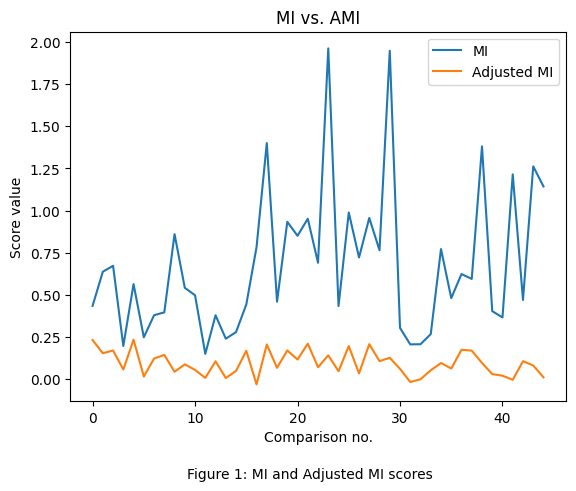

In [9]:
import matplotlib.pyplot as plt
plt.plot(MI_scores, label = "MI")
plt.plot(adj_MI_scores, label = "Adjusted MI")
plt.xlabel('Comparison no.')
plt.ylabel('Score value')
plt.title('MI vs. AMI')
plt.legend()
plt.plot()

txt="Figure 1: MI and Adjusted MI scores"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=10)

The Mutual Information(MI) score is a measure of the similarity and the mutual dependence between the predictions of two annotators that is affected by the number of clusters. Whereas, Adjusted Mutual Information (AMI) score is a special adjustment of the MI score to account for the expected MI value under random chance. 
Here, the main difference between the MI and AMI scores is that the Adjusted MI scores have a lower mean and median, indicating a shift towards lower values compared to the raw MI scores. Additionally, the Adjusted MI scores have far less variability, as indicated by their lower standard deviation. In Figure 1 we can verify these conclusions diagramatically. \
Some sort of adjustment or transformation has been applied to the MI scores, to define the adjusted MI scores, resulting in a narrower and lower distribution of values. AMI values are more reliable due to the attention they give to the factor of chance. \
AMI scores typically take values in [-1,1]. In our example, they tend to have values close to 0 (the maximum value is approx. 0.23). This suggests no significant agreement beyond what would be expected by chance is met. Thus, it seems that the annotators worked at most without collaboration. \
Finally, we can see that the AMI scores have at most cases a similar trend to the MI scores, but of course with much smaller variance.

B1.

In [10]:
proverbs = annot['text']
num_proverbs = len(proverbs)
matrix = np.zeros((num_proverbs, num_proverbs))                  #Initialize our matrix

for i in range(num_proverbs):
    for j in range(i, num_proverbs):
        
        count_agree = np.sum(annot.iloc[i, 1:11] == annot.iloc[j, 1:11])                                     #Find where we have matches
        total_annotations = len(annot.columns) - 6                                                    # Exclude the 'text' column and the LLM annotators
        relative_frequency = count_agree / total_annotations                                             #Find the frequency

        
        matrix[i, j] = relative_frequency                                                               # Fill in the matrix with the relative frequency
        matrix[j, i] = relative_frequency


print(pd.DataFrame(matrix, columns=proverbs, index=proverbs))                                           # Print the matrix

text                                                Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει  \
text                                                                                          
Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει                                                 1.0   
Τα 'θελες και τα 'παθες                                                                 0.2   
Αδειανός μασκαράς, παραχέρ 'τ' χουριού                                                  0.3   
Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντά...                                      0.2   
Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε                                               0.2   
...                                                                                     ...   
Σαράντα καλόγεροι, ο καθένας με τον πόνο τ'                                             0.3   
Θέλει κι ο Μούτσιος καφέ!                                                               0.3   
Ξέρεις και συ που πάει του χωριού η αγγέλη        

B2.

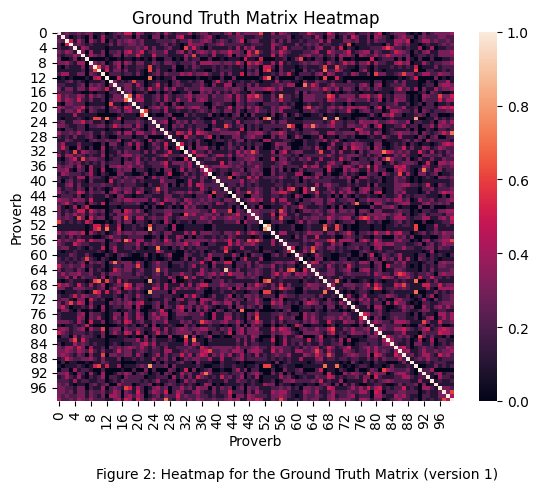

In [11]:
#First version of our heatmap
sns.heatmap(matrix,  annot=False, fmt=".2f", cbar=True)
plt.xlabel('Proverb')
plt.ylabel('Proverb')
plt.title('Ground Truth Matrix Heatmap')
txt2="Figure 2: Heatmap for the Ground Truth Matrix (version 1)"
plt.figtext(0.5, -0.05, txt2, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

In [12]:
print(matrix.T == matrix)                            # Our matrix is proved to be symmetric 

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


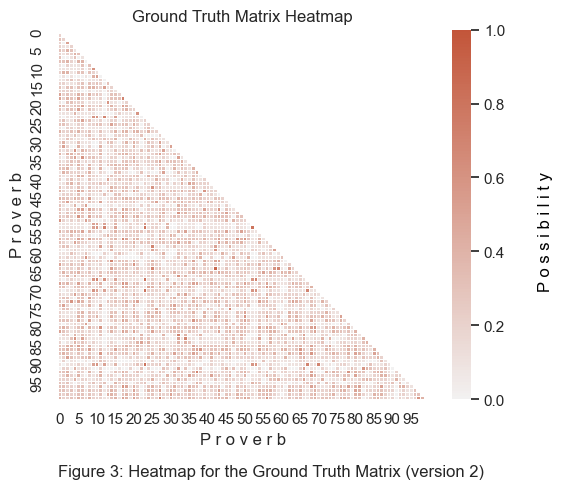

In [13]:
#Second version for our heatmap

sns.set_theme(style="white")
mask = np.zeros_like(matrix, dtype=bool)                   # Generating a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 20, as_cmap=True)        # Generating a custom diverging colormap

# Draw the heatmap, including the mask and custom fixes (e.g., the line width or the color bar)
sns.heatmap(matrix, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5);

plt.xlabel('P r o v e r b')
plt.ylabel('P r o v e r b')
plt.text(130, 70, 'P o s s i b i l i t y', rotation=90, fontsize=12, color='black') #Add an extra label to characterize the possibilities
plt.title('Ground Truth Matrix Heatmap')
txt3="Figure 3: Heatmap for the Ground Truth Matrix (version 2)"
plt.figtext(0.5, -0.05, txt3, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In Figure 2, we see the first version of our heatmap. Knowing that our matrix is symmetric, it was wiser to remove the upper triangle, thus ending up in Figure 3. In Figure 3, we tried to optimize the colors in order for the reader to recognize easier the quantity of the possibility that 2 proverbs are put in the same cluster. The main problem is that in Figure 2 the lowest possibilities, which are the most frequent ones, had the darkest shades of color, thus the lighter ones were not easily spotted by the human eye. \
In Figure 3, our optimization meets the standards of a publication - quality visualization: 

1) **Know your Audience**. This heatmap can be considered fully understandable even for the general public, which is also the most difficult one to show to, because our visualization needs to be exactly as detailed. 
2) **Identify your Message**. This heatmap includes both title and labels for every axis, even for the ranging values on the right [0,1]. So our figure is able to convey a striking message at first glance. This simplification allows viewers to quickly grasp trends and patterns without getting lost in the details.
3) **Adapt the Figure to the Support Medium**. The viewer can quickly understand what is displayed in the figure and what it represents, even if this figure is used in oral presentantions for a limited time.
4) **Captions are not optional**. A very important rule is to put captions, as we did here. A caption for the figure is included, while also there are titles for every axis and the entire heatmap.
5) **Do Not Trust the Defaults**. In Figure 2, we 'trusted' the default settings of a heatmap example. By adjusting the colors in Figure 3,  we produced a much better for the human eye heatmap.
6) **Use color effectively**. As stated earlier, the target was to have a color diverging from light to dark values, with easily seen 'categories' and patterns (e.g. for 0.2, 0.4 etc.)
7) **Do Not Mislead the Reader**. This heatmap is a simple way to convey our message and making sure to use labels, ticks, title, and the full range of values when relevant, there is no place for confusion by the readers.
8) **Avoid “Chartjunk”**. Our heatmap does not contain more than necessary labels and categories, providing and explaining the most important ones and has included only the down triangle. Including all the heatmap is not useful here because our matrix is symmetric.
9) **Message Trumps Beauty**. The message and readability of the figure is the most important aspect while beauty is only an option, as noted in Figure 3.
10) **Get the Right Tool**. Here, we chose a heatmap of the seaborn library in Python, which accurately represents the information we would like to share.

C1.

The 5 personas that participated were:

1) A linguistics teacher ( [LLMAnnot1](https://chat.openai.com/share/00e619b5-3e66-4872-857f-253c8494f45e?fbclid=IwAR2NGz8XDJVWwosEY6_fnyvee8tY-ARIHI2FBDv35dvV7MKattFdCFFjp7I))
2) A football player from Greece  ([LLMAnnot2](https://chat.openai.com/share/d7d301ee-7d18-4d6e-bbb6-d16eae63553a?fbclid=IwAR2NGz8XDJVWwosEY6_fnyvee8tY-ARIHI2FBDv35dvV7MKattFdCFFjp7I))
3) A female programmer from India ([LLMAnnot3](https://chat.openai.com/share/8f34f7dc-dc02-4352-b541-7b56a4136d95?fbclid=IwAR16OuPKTsIVAo5mefWGa-jt6Wtg_sUuM7sBNT87LjTzhYPPeeAyABD68nc))
4) An American student ([LLMAnnot4](https://chat.openai.com/share/94f64b77-30bc-469d-84c7-fb1da8d92152?fbclid=IwAR2JctaGgW7A8tAjIPZUP_5wZ3w1yvwPj-Ufibdssa4heSg6e8D1J7nFYFE))
5) A Greek Granny (80 years old). ([LLMAnnot5](https://chat.openai.com/share/ae3ce35b-44f6-4414-b2ad-42e241be6d92?fbclid=IwAR01zTr_5d9JfNVI0UJQSIkRZ3xSy0y8EKhBPyWWZ-FwcABQ75bj9GuJ7zM))

The results of the LLM clusterings were put in the original csv file, in the columns 12:16.

C2.

In [14]:
max_AMI = -2
MI_scores2 = []
adj_MI_scores2 = []
annotators = annot.columns.values[1:11]                                                         #Annotators
LLM_annotators = annot.columns.values[11:]                                                      #LLMs
sum_Adj = [0,0,0,0,0]  # Sum of AMIs for every LLM
max_sum_adj = -100
for j in range (0,len(LLM_annotators)):
    
    for i, annotator1 in enumerate(annotators):
        
        first_annot = annotator1
        annotator2 = LLM_annotators[j]                                  # Define the second annotator
        
        MI_score = mutual_info_score(annot[annotator1], annot[annotator2])
        MI_scores2.append(MI_score)                                                          #Find MI score
        
        adj_MI_score =  adjusted_mutual_info_score(annot[annotator1], annot[annotator2])
        adj_MI_scores2.append(adj_MI_score)                                                  #Find AMI score
        sum_Adj[j] = sum_Adj[j] + adj_MI_score
        print("MI Score between ", annotator1, "and ", annotator2, ": ", MI_score)
        
        print("Adjusted MI Score between ", annotator1, "and ", annotator2, ": ", adj_MI_score)              
        print("\n")

  
        
        
        if (adj_MI_score >= max_AMI):
            max_AMI = adj_MI_score                                                                   #Find the maximum AMI score
            first = annotator1                                                                       # Keep the annotators
            second = annotator2
            
    if sum_Adj[j] >= max_sum_adj:                                                                    #Find the maximum sum of AMIs for each LLM
        max_sum_adj = sum_Adj[j]
        LLMannot = LLM_annotators[j]

print("The pair with the highest AMI score consists of the annotators ", first, " and ", second, " with an AMI score of ", max_AMI)
print("\n")
print("Sum of AMIs for each LLM:",  "\n")
print("LLMAnnot1: ", sum_Adj[0])
print("LLMAnnot2: ", sum_Adj[1])
print("LLMAnnot3: ", sum_Adj[2])
print("LLMAnnot4: ", sum_Adj[3])
print("LLMAnnot5: ", sum_Adj[4])
print("The best LLM annotator, concerning the overall sum of AMI values vs all the human annotators is", LLMannot, "with an AMI score of ", max_sum_adj)

MI Score between  f3352321 and  LLMAnnot1 :  0.06340486344724784
Adjusted MI Score between  f3352321 and  LLMAnnot1 :  -0.018409841024832476


MI Score between  f3352310 and  LLMAnnot1 :  0.04799733785971616
Adjusted MI Score between  f3352310 and  LLMAnnot1 :  -0.031012700100849187


MI Score between  f3352311 and  LLMAnnot1 :  0.20852693769565156
Adjusted MI Score between  f3352311 and  LLMAnnot1 :  -0.0230403745223682


MI Score between  f3352316 and  LLMAnnot1 :  0.2642528521019169
Adjusted MI Score between  f3352316 and  LLMAnnot1 :  0.0027607103042026114


MI Score between  f3352318 and  LLMAnnot1 :  0.08114363011466977
Adjusted MI Score between  f3352318 and  LLMAnnot1 :  -0.013800101965447623


MI Score between  f3352314 and  LLMAnnot1 :  0.11814874220492666
Adjusted MI Score between  f3352314 and  LLMAnnot1 :  -0.01046238464161409


MI Score between  f3352315 and  LLMAnnot1 :  0.1267238478110551
Adjusted MI Score between  f3352315 and  LLMAnnot1 :  -0.014565114925289684


MI S

We will pick the Adjusted Mutual Information (AMI) score for our analysis. As stated earlier, AMI is not affected by chance and the number of the clusters. At first, we will take the scores for all possible combinations (not the case when we calculated the sum of AMIs for each LLM). The calculated AMI scores are:

In [15]:
print('Adjusted MI scores:', adj_MI_scores2)


Adjusted MI scores: [-0.018409841024832476, -0.031012700100849187, -0.0230403745223682, 0.0027607103042026114, -0.013800101965447623, -0.01046238464161409, -0.014565114925289684, -0.024192745981106448, -0.013926466044533233, -0.018018971958476206, -0.004328574978621747, 0.01499572233140222, -0.04122754130991269, -0.052023688331834364, 0.01160774108050263, -0.003133588273131507, -0.0007789340282211534, 0.033193520516267325, -0.04687489753562112, 0.023579001334157707, -0.009150337508272958, 0.019249425750266853, 0.0011462409174244658, -0.0019515863732916987, -0.02147772071786605, 0.018466554526674346, -0.03373159903100267, 0.003739703840821717, 0.009228358353783165, 0.02631899320598035, 0.023193302578761024, 0.009253109177239378, -0.024912808184779048, -0.023416491556416674, -0.011389986411220635, 0.019017381099419188, -0.018580121433256668, -0.0358241305041479, 0.010363420615355652, -0.001025285282629996, -0.02245648990474335, 0.008268507265747824, 0.02905644932693609, -0.00710904562689

The best LLM clustering can be considered the one with the maximum value. Recall that AMI takes values in [-1,1], with values close to 0 
indicating independence. Values close to 1 indicate perfect agreement, while values close to -1 show perfect disagreement. Thus, high AMI scores can imply better clustering.

Text(0.5, -0.05, 'Figure 4:  Comparing MI to AMI scores')

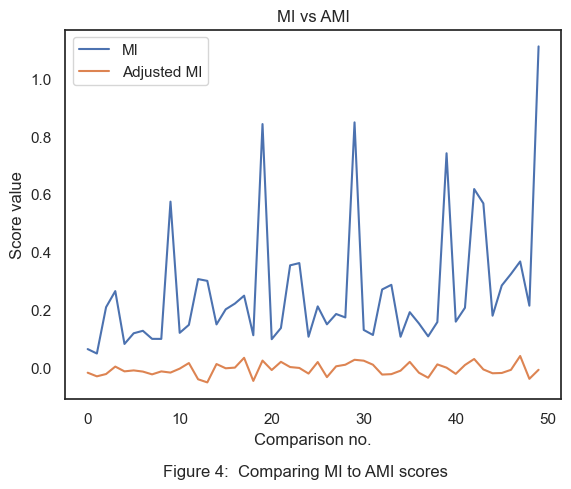

In [16]:
plt.plot(MI_scores2, label = 'MI')
plt.plot(adj_MI_scores2, label = "Adjusted MI")

plt.xlabel('Comparison no.')
plt.ylabel('Score value')
plt.title('MI vs AMI')
plt.legend()
plt.plot()
#plt.ylim(-0.1, 0.1)  
txt="Figure 4:  Comparing MI to AMI scores"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)

The big variances in the values of MI prove again that MI is affected by the number of clusters. Thus, it was wiser to use the AMI for our purposes.

Text(0.5, -0.05, 'Figure 5:  Adjusted MI scores')

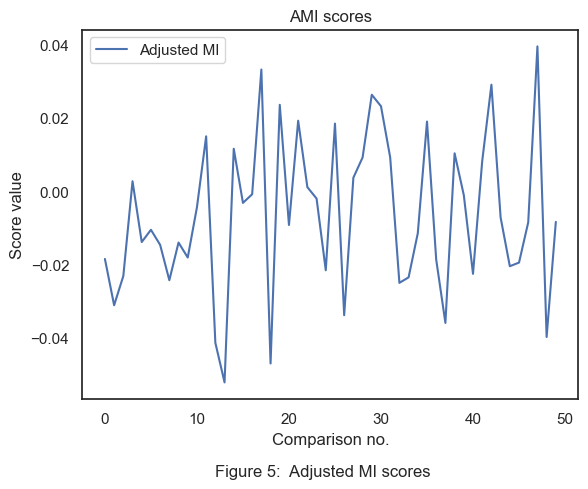

In [17]:
plt.plot(adj_MI_scores2, label = "Adjusted MI")

plt.xlabel('Comparison no.')
plt.ylabel('Score value')
plt.title('AMI scores')
plt.legend()
plt.plot()

txt="Figure 5:  Adjusted MI scores"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)


Next, we will consider the case when we calculated the sum of the AMIs for each LLM Annotator. In this case, LLMAnnot3 performed better overall to the other LLM Annotators:

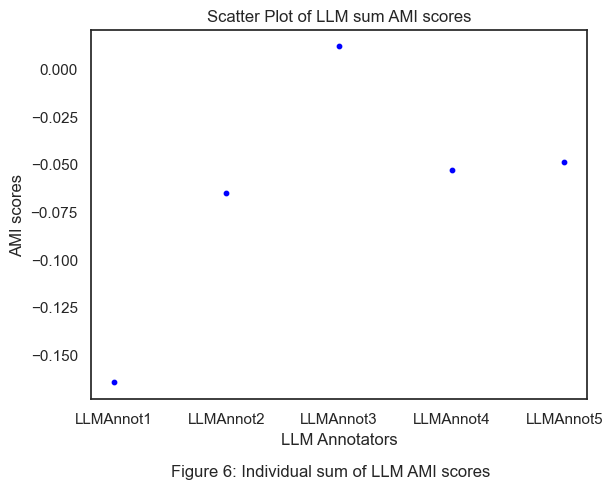

In [18]:
y = ["LLMAnnot1", "LLMAnnot2", "LLMAnnot3", "LLMAnnot4", "LLMAnnot5"]

plt.scatter(y, sum_Adj, label='Scatter Plot', color='blue', marker='o', s=10)


plt.xlabel('LLM Annotators')
plt.ylabel('AMI scores')
plt.title('Scatter Plot of LLM sum AMI scores')
txt="Figure 6: Individual sum of LLM AMI scores"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()


In conclusion:
1) In the case of single LLM vs single Human Annotator, LLMAnnot5 was the winner from the LLMs. Recall that the persona behind this LLM is a greek Granny, who knows about greek proverbs.
2) In the case where we calculated AMIs of one LLM vs the sum of human annotators, LLMAnnot3 was the winner. Here, the winning persona was the female programmer from India.
3) In both cases, the results are not far from 0, indicating that there was little to no agreement between the human clusterings and the LLM ones.

Bonus.

In this example, I considered the first case of single LLM vs single Human Annotator, where Annot5 was the winner . I took only the first 30 examples because I could not use the LLM for the thousands of examples for free. You can find the clustering by the LLM [here](https://chat.openai.com/share/8583152d-0038-4311-b060-8695f14679d9)  and in the CSV file. Note that in the CSV file I put the proverbs in ascending order of the clusters.